In [186]:
%matplotlib inline

In [187]:
import numpy as np
import os
import networkx as nx
import seaborn as sns


from numpy.linalg import eigh
from scipy import sparse as sp
from scipy.sparse import issparse
from matplotlib import pyplot as plt
from collections import defaultdict
from functools import reduce

from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs

from helpers import (
    signed_layout, draw_nodes, draw_edges, flatten, 
    dict2array, signed_group_conductance,
    conductance_by_sweeping,
    get_borderless_fig, 
    labels2groups,
    num_ccs, cc_sizes
) 
from sweeping import sweeping_scores_using_ppr
from motif_adjacency import motif_eef_anchored, motif_fff, motif_ff

In [188]:
M1, M2, M3 = 'm1', 'm2', "m3"
motif2f = {
    M1: motif_eef_anchored,
    M2: motif_fff,
    M3: motif_ff
}

In [225]:
graph_name = 'tribe'
motif_ids = [M1, M2, M3]


path = 'graphs/{}.pkl'.format(graph_name)
fig_dir = os.path.join(
    'figs/motif_clustering_demo/',
    graph_name,
    '-'.join(sorted(motif_ids))
)    

if graph_name == 'tribe':
    # the following are working examples
    query = 8
    alpha = 0.5
#     query = 0
#     alpha = 0.25
elif graph_name == 'cloister':
#     query = 14
#     alpha = 0.5
#     query = 12
#     alpha = 0.5
    query = 2
    alpha = 0.5
elif graph_name == 'congress':
    query = 91
    alpha = 0.25
elif graph_name == 'toy':
    query = 0
    alpha = 0.5
    
FIG_FORMAT = 'pdf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
print('fig_dir', fig_dir)    

fig_dir figs/motif_clustering_demo/tribe/m1-m2-m3


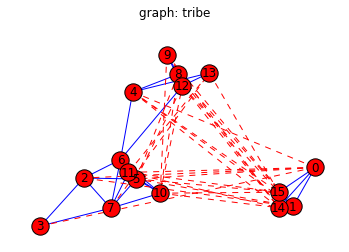

In [226]:
g = nx.read_gpickle(path)

fig, ax = get_borderless_fig()
if graph_name == 'toy':
    pos = g.graph['pos']
else:
    pos = signed_layout(g)
    
draw_nodes(g, pos, ax=ax)
# nx.draw_networkx_nodes(g, pos, node_size=100)
draw_edges(g, pos, ax=ax)
ax.set_title('graph: {}'.format(graph_name))
fig.savefig(fig_dir + '/graph.'+FIG_FORMAT)

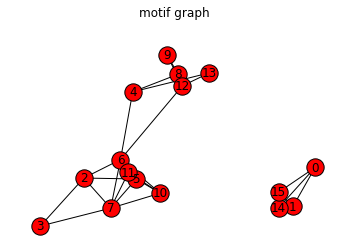

In [227]:
A = nx.adj_matrix(g, weight='sign')

W = reduce(
    lambda a, b: a + b,
    [motif2f[m](A) for m in motif_ids],
    sp.dok_matrix(A.shape).tocsr()
)    
    
g_motif = nx.from_scipy_sparse_matrix(W)
    
fig, ax = get_borderless_fig()
nx.draw_networkx(g_motif, pos=pos, with_labels=True, node_size=300, ax=ax)
ax.set_title('motif graph')
fig.savefig(fig_dir + '/motif-graph.' + FIG_FORMAT)

get node score (local) w.r.t node 8
best position 5
community [8, 9, 12, 4, 13]


/home/cloud-user/code/signed/helpers.py:430: RuntimeWarning: invalid value encountered in true_divide
  scores = num_cut / vols


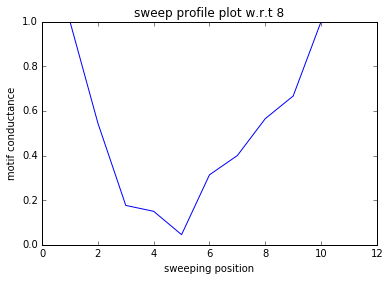

In [228]:
if False:
    if g_motif.degree(query) == 0:
        raise ValueError('query {} has degree 0 in motif graph'.format(query))

    motif_A = nx.adjacency_matrix(motif_cc, weight='weight')
    print('get node score (local) w.r.t node {}'.format(query))
    order, sweep_positions, sweep_scores = sweeping_scores_using_ppr(
        g_motif, query, alpha, A=W
    )



    fig, ax = plt.subplots(1, 1)
    ax.plot(sweep_positions, sweep_scores)
    ax.set_title('sweep profile plot w.r.t {}'.format(query))
    ax.set_xlabel('sweeping position')
    ax.set_ylabel('motif conductance')

    # get the best community
    best_pos = np.argmin(sweep_scores)
    comm = order[:best_pos+1]
    print('best position', best_pos+1)

    # map back the lcc nodes to g
    print('community', comm)
    fig.savefig(fig_dir + '/sweep-profile-plot.' + FIG_FORMAT)
    
else:
    cc_list = list(nx.connected_components(g_motif))
    n2cc = {}
    for i, cc in enumerate(cc_list):
        for n in cc:
            n2cc[n] = i
    cc_nodes = cc_list[n2cc[query]]
    motif_cc = g_motif.subgraph(cc_nodes)

    g2cc_map = {n: i for i, n in enumerate(cc_nodes)}
    cc2g_map = {i: n for i, n in enumerate(cc_nodes)}
    motif_cc = nx.relabel_nodes(motif_cc, mapping=g2cc_map)

    cc_query = g2cc_map[query]

    if motif_cc.degree(cc_query) == 0:
        raise ValueError('query {} has degree 0 in motif graph'.format(query))

    motif_A = nx.adjacency_matrix(motif_cc, weight='weight')
    print('get node score (local) w.r.t node {}'.format(query))
    order, sweep_positions, sweep_scores = sweeping_scores_using_ppr(
        motif_cc, cc_query, alpha, A=motif_A
    )

    fig, ax = plt.subplots(1, 1)
    ax.plot(sweep_positions, sweep_scores)
    ax.set_title('sweep profile plot w.r.t {}'.format(query))
    ax.set_xlabel('sweeping position')
    ax.set_ylabel('motif conductance')

    # get the best community
    best_pos = np.argmin(sweep_scores)
    cc_comm = order[:best_pos+1]
    print('best position', best_pos+1)

    # map back the lcc nodes to g
    comm = [cc2g_map[n] for n in cc_comm]
    print('community', comm)
    fig.savefig(fig_dir + '/sweep-profile-plot.' + FIG_FORMAT)

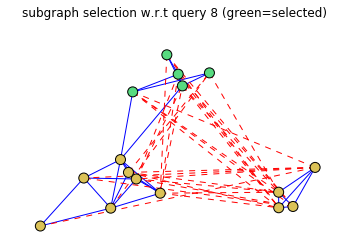

In [229]:
pal = sns.color_palette('hls', 8)
# sns.palplot(pal)

node_color = np.zeros((g.number_of_nodes(), 3))
for i in np.arange(g.number_of_nodes()):
    if i in comm:
        node_color[i] = pal[3]
    else:
        node_color[i] = pal[1]
    
    
fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(g, pos, node_color=node_color, node_size=100, ax=ax)
draw_edges(g, pos, ax=ax)
ax.set_title('subgraph selection w.r.t query {} (green=selected)'.format(query))
fig.savefig(fig_dir + '/subgraph-selection.' + FIG_FORMAT)

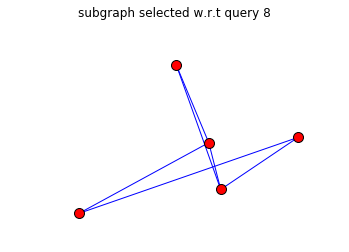

In [230]:
subg = g.subgraph(comm)
mapping = {n: i for i, n in enumerate(comm)}
subg = nx.relabel_nodes(subg, mapping=mapping)
subg_pos = {mapping[n]: pos[n] for n in comm}

fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(subg, subg_pos, node_size=100, with_label=False)
# nx.draw_networkx_labels(subg, subg_pos, labels={mapping[n]: n for n in comm})
draw_edges(subg, subg_pos)
ax.set_title('subgraph selected w.r.t query {}'.format(query))
fig.savefig(fig_dir + '/subgraph-selected.' + FIG_FORMAT)

In [231]:
from eval_helpers import community_summary

In [232]:
subg = g.subgraph(comm)

In [233]:
community_summary(subg, g)

OrderedDict([('size', 5),
             ('inter_neg_edges', 1.0),
             ('intra_pos_edges', 0.8571428571428571),
             ('f1_pos_neg', 0.923076923076923),
             ('avg_cc', (0.3333333333333333,))])